[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/franckalbinet/mirzai/blob/main/nbs/paper/13_cnn_lr_finder.ipynb)

# 4.1 CNN learning rate finder

> Implementing Learning Rate Finder as describued in Smith, L.N., 2017. Cyclical learning rates for training neural networks, in: 2017 IEEE Winter Conference on Applications of Computer Vision (WACV). IEEE, pp. 464–472. https://arxiv.org/abs/1506.01186]

In [ ]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive',  force_remount=False)
    !pip install mirzai
else:
    %load_ext autoreload
    %autoreload 2

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.2 MB 10.7 MB/s 
     |████████████████████████████████| 1.4 MB 64.4 MB/s 
     |████████████████████████████████| 957 kB 65.0 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [ ]:
from pathlib import Path
import pickle

# import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from mirzai.data.loading import load_kssl
from mirzai.data.selection import (select_y, select_tax_order, select_X)
from mirzai.data.transform import log_transform_y
from mirzai.data.torch import DataLoaders, SNV_transform
from mirzai.training.cnn import (Model, weights_init)
from mirzai.training.cnn import Learner

# Deep Learning stack
import torch
from torch.optim import Adam
from torch.nn import MSELoss

from fastcore.transform import compose

import warnings
warnings.filterwarnings('ignore')

## 1. Load and transform

### Load data

In [ ]:
src_dir = '/content/drive/MyDrive/research/predict-k-mirs-dl/data/potassium'
fnames = ['spectra-features.npy', 'spectra-wavenumbers.npy', 
          'depth-order.npy', 'target.npy', 
          'tax-order-lu.pkl', 'spectra-id.npy']


X, X_names, depth_order, y, tax_lookup, X_id = load_kssl(src_dir, fnames=fnames)
transforms = [select_y, select_tax_order, select_X, log_transform_y]

data = X, y, X_id, depth_order
X, y, X_id, depth_order = compose(*transforms)(data)
print(X.shape)

(40132, 1764)


### Create data loaders

In [ ]:
split_ratio = 0.1

# Train/test split
X_train, X_test, y_train, y_test, tax_order_train, tax_order_test = train_test_split(X, 
                                                                                     y, 
                                                                                     depth_order[:,1], 
                                                                                     test_size=split_ratio,
                                                                                     random_state=42)

# Further train/valid split
X_train, X_valid, y_train, y_valid, tax_order_train, tax_order_valid = train_test_split(X_train, 
                                                                                      y_train,
                                                                                      tax_order_train, 
                                                                                      test_size=split_ratio, 
                                                                                      random_state=42)


dls = DataLoaders((X_train, y_train, tax_order_train), 
                  (X_valid, y_valid, tax_order_valid),
                  (X_test, y_test, tax_order_test), 
                  transform=SNV_transform())
training_generator, validation_generator, test_generator = dls.loaders()

## 2. Setup

In [ ]:
# Is a GPU available?
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
print(f'Runtime is: {device}')

n_epochs = 20
step_size_up = 5
criterion = MSELoss() # Mean Squared Error loss

Runtime is: cuda:0


### 4. Train

In [ ]:
## LR finder
model = Model(X.shape[1], out_channel=16).to(device)

opt = Adam(model.parameters(), lr=1e-4)
model = model.apply(weights_init)

learner = Learner(model, criterion, opt, n_epochs=n_epochs, 
                  scheduler=None, early_stopper=None,
                  tax_lookup=tax_lookup.values(), verbose=True)

lrs, losses = learner.lr_finder(training_generator, end=0.1, n_epochs=8)

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7


### 5. Save & load


In [ ]:
dest_dir = Path('/content/drive/MyDrive/research/predict-k-mirs-dl/dumps/cnn/lr_finder')
with open(dest_dir/f'cnn-lr.pickle', 'wb') as f: 
    pickle.dump([lrs, losses], f)

In [ ]:
src_dir = Path('/content/drive/MyDrive/research/predict-k-mirs-dl/dumps/cnn/lr_finder')
with open(src_dir/f'cnn-lr.pickle', 'rb') as f: 
    lrs, losses = pickle.load(f)

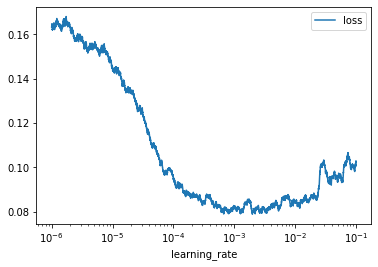

In [ ]:
pd.DataFrame({'learning_rate': lrs, 'loss': losses}).plot(x='learning_rate', y='loss', logx=True);